In [136]:
import pandas as pd

reducedPapers = pd.read_csv(
    "../processedData/processedData.csv",
    sep=','
)
reducedPapers.dropna(subset = ['processedText'], inplace = True, how='any')
reducedPapers.reset_index(drop=True, inplace=True)
reducedPapers.head()

,Unnamed: 0,timePeriod,index,processedText
0,1,1800-01-01,2,gallant general command well know soon arrive
1,2,1800-01-01,3,pitt doubt necessary insert clause bill purpos...
2,3,1800-01-01,4,hussey inform romish bishop waterford appoint ...
3,4,1800-01-01,5,former time former war invasion often threaten...
4,5,1800-01-01,6,support motion harm much good


In [137]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [138]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words='english')


In [139]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)

In [140]:
import pickle
reducedPapers.loc[:, 'processedText'] = reducedPapers['processedText'].astype("str")
topics, probs = model.fit_transform(reducedPapers['processedText'])
with open('../processedData/topics.pickle', 'wb') as f:
    pickle.dump(topics, f)

Batches:   0%|          | 0/647 [00:00<?, ?it/s]

2023-04-10 09:30:09,683 - BERTopic - Transformed documents to Embeddings
2023-04-10 09:30:18,190 - BERTopic - Reduced dimensionality
2023-04-10 09:30:23,222 - BERTopic - Clustered reduced embeddings


In [142]:
hierarchical_topics = model.hierarchical_topics(reducedPapers['processedText'])
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 35/35 [00:00<00:00, 87.07it/s]

.
├─royal_room_royal highness_highness_pergami
│    ├─room_royal highness_highness_pergami_royal
│    │    ├─■──bed_sleep_night_evening_day ── Topic: 29
│    │    └─room_royal highness_highness_pergami_royal
│    │         ├─■──bergami_room_sleep_bed_countess ── Topic: 30
│    │         └─■──pergami_royal highness_highness_royal_room ── Topic: 6
│    └─■──duke_royal_duke york_royal family_york ── Topic: 35
└─make_lord_catholic_country_state
     ├─catholic_lord_make_ireland_noble
     │    ├─noble_noble lord_lord_earl_noble earl
     │    │    ├─■──noble_noble lord_lord_speech_question ── Topic: 18
     │    │    └─■──noble_earl_noble earl_lord_noble lord ── Topic: 21
     │    └─catholic_ireland_make_state_lord
     │         ├─lord_make_case_state_subject
     │         │    ├─lord_make_case_state_subject
     │         │    │    ├─■──repeal_measure_amendment_wish_propose ── Topic: 17
     │         │    │    └─lord_make_case_state_subject
     │         │    │         ├─make_lord_ca

In [149]:
fig = model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

fig.write_image("output.png", engine="kaleido", scale=3)
fig.show()

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [147]:
import pickle
with open('../processedData/topics.pickle', 'wb') as f:
    pickle.dump(topics, f)

In [135]:
model.visualize_barchart(top_n_topics=38, n_words=5, title='<b>Top Word Scores')

In [99]:
topics_over_time = model.topics_over_time(reducedPapers['processedText'],
                                                reducedPapers['timePeriod'],
                                                global_tuning=True,
                                              evolution_tuning=True,
                                                nr_bins=13)

with open('../processedData/topics_over_time.pickle', 'wb') as f:
    pickle.dump(topics_over_time, f)

3it [00:06,  2.26s/it]


In [100]:
#model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
model.visualize_topics_over_time(topics_over_time)


In [101]:
#model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
#model.visualize_topics_over_time(topics_over_time)
model.visualize_topics_over_time(topics_over_time, topics=[24, 18])


In [130]:
model.visualize_topics()

In [131]:
similarWords = (
    "king "
    "prince "
    "princess "
    "queen "
    "royal "
    "royalty "
    "majesty "
)

In [104]:
similar_topics, similarity = model.find_topics(similarWords)

In [105]:
model.get_topic(similar_topics[0])

[('regent', 0.04113937856550322),
 ('prince', 0.0400487882459707),
 ('majesty', 0.039445763884418984),
 ('prince regent', 0.036187118600558066),
 ('royal', 0.03539040567597022)]

In [106]:
import pandas as pd
from umap import UMAP
%matplotlib inline

embeddings_vis = model._extract_embeddings(reducedPapers['processedText'], method="document")
umap_model_vis = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine').fit(embeddings_vis)
df_vis = pd.DataFrame(umap_model_vis.embedding_, columns=["x", "y"])
df_vis["topic"] = topics

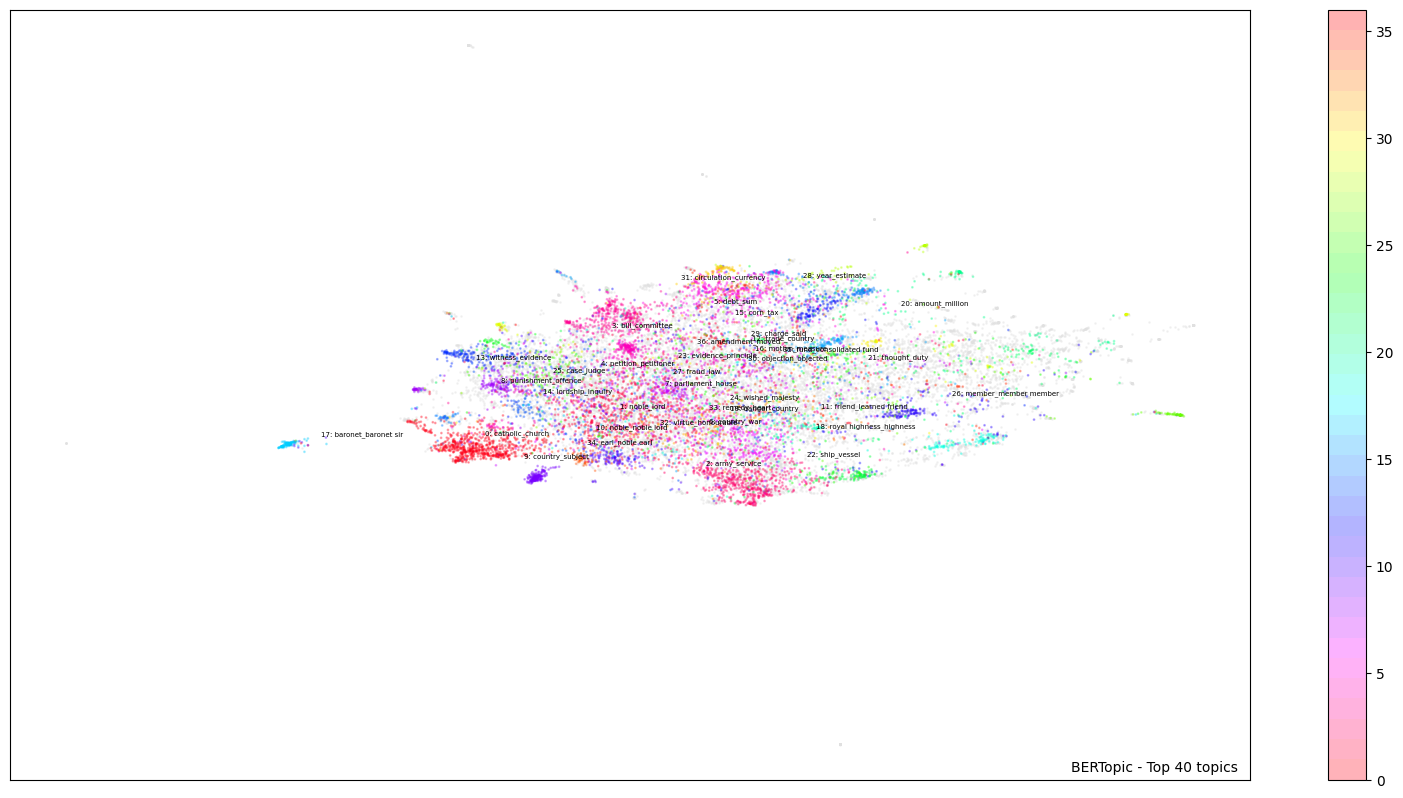

In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot parameters
top_n = 40
fontsize = 5 #12

to_plot = df_vis.copy()
to_plot[df_vis.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

n_topics = len(np.unique(topics))
cmap = plt.get_cmap('hsv_r', n_topics)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:2]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(scatter)
plt.savefig("../diagramOutput/mergeCluster.png", dpi=900, bbox_inches='tight')
plt.show()